Họ tên: Phạm Nguyễn Xuân Trường

MSSV: 20520835

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display 
import sys
import os

# I. Set up required functions

$f(x) = \displaystyle\sum_{i=1} ^{d} x_i^2$

In [180]:
def Sphere(x):
  return sum([xi**2 for xi in x])

In [ ]:
Sphere([1, 2, 2])

9

$f(x) = \displaystyle\sum_{i=1} ^{d} x_i^2 + ( \sum_{i=1} ^{d} 0.5ix_i)^2 + ( \sum_{i=1} ^{d} 0.5ix_i)^4$

In [181]:
def Zakharov(x):
  result = sum([xi**2 for xi in x])
  sum_with_i = 0
  for i in range(len(x)):
    sum_with_i += 0.5 * (i+1) * x[i]
  
  return result + sum_with_i**2 + sum_with_i**4

In [ ]:
Zakharov([1, 1, 1])

93.0

$f(x) = \displaystyle\sum_{i=1}^{d-1}[100(x_{i+1} -x_i^2)^2 + (x_i - 1)^2]$

In [182]:
def Rosenbrock(x):
  result = 0
  for i in range(len(x) - 1):
    result += 100*(x[i+1] - x[i]**2)**2 + (x[i]-1)**2
  return result

In [ ]:
Rosenbrock([1,0,0])

101

$f(x) = \displaystyle - \sum_{i=1}^{d} \sin(x_i)\sin^{2m} (\frac {ix_i^2} {π}) $

In [183]:
def Michalewicz(x, m=10):
  result = 0
  for i in range(len(x)):
    result += np.sin(x[i]) * np.sin(( (i+1) * x[i]**2 ) / np.pi) ** (2*m)
  return -1 * result

In [ ]:
Michalewicz([2.2, 1.57])

-1.801140718473825

$f(x) = \displaystyle -a \exp(-b \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2 } ) - \exp(\frac{1}{d} \sum_{i=1}^{d} \cos(cx_i) ) + a + \exp(1)$

In [184]:
def Ackley(x, a=20, b=0.2, c=2*np.pi):
  d = len(x)
  square_sum = sum([xi**2 for xi in x])
  cos_sum = sum([ np.cos(c*xi) for xi in x])
  result = -a*np.exp(-b * np.sqrt(square_sum / d)) - np.exp(cos_sum / d) + a + np.exp(1)
  return result

In [ ]:
Ackley([0, 0])

4.440892098500626e-16

## DE

In [177]:
def de(fobj, bounds, F_scale=0.8, cross_prob=0.7, popsize=20, max_evaluations=100000):
    dimensions = len(bounds)

    lower_bound, upper_bound = np.asarray(bounds).T

    diff = np.fabs(lower_bound - upper_bound)

    pop = lower_bound + diff * np.random.rand(popsize, dimensions)

    fitness = np.asarray([fobj(ind) for ind in pop])

    best_idx = np.argmin(fitness)

    best = pop[best_idx]

    results = []
    all_pops = []
    evals = []

    results.append((np.copy(best), fitness[best_idx]))
    all_pops.append(np.copy(pop))
    evals.append(popsize)
    # for i in range(max_iters):
    while evals[-1] < max_evaluations:
        for j in range(min(popsize, max_evaluations - evals[-1])):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F_scale * (b-c), lower_bound, upper_bound)

            cross_points = np.random.rand(dimensions) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            
            trial = np.where(cross_points, mutant, pop[j])

            f = fobj(trial)

            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial

        evals.append(evals[-1] + min(popsize, max_evaluations - evals[-1]))
        results.append((np.copy(best), fitness[best_idx]))
        all_pops.append(np.copy(pop))

    
    return results, all_pops, evals

In [ ]:
results, all_pops, evals = de(Sphere, [(-5.12, 5.12)]*2, popsize=128, max_evaluations=100000)

In [ ]:
results[-5:]

[(array([ 7.81437429e-72, -1.24905819e-70]), 7.80218407173291e-142),
 (array([ 7.81437429e-72, -1.24905819e-70]), 7.80218407173291e-142),
 (array([ 7.81437429e-72, -1.24905819e-70]), 7.80218407173291e-142),
 (array([ 7.81437429e-72, -1.24905819e-70]), 7.80218407173291e-142),
 (array([ 7.81437429e-72, -1.24905819e-70]), 7.80218407173291e-142)]

## CEM

In [178]:
def cem(fobj, bounds, sigma_init=1.0, epsilon=0, popsize=20, elite_frac=10,  max_evaluations=100):

    dimensions = len(bounds)
    
    elitesize = int(popsize * elite_frac)
    lower_bound, upper_bound = np.asarray(bounds).T

    diff = np.fabs(lower_bound - upper_bound)

    mu = lower_bound + diff * np.random.rand(dimensions)

    results = []
    all_pops = []
    evals = []
    evals.append(0)

    # sigma = sigma_init * dimensions
    sigma = sigma_init * np.identity(dimensions)

    while evals[-1] < max_evaluations:
        offspring = np.random.multivariate_normal(mu, sigma, popsize)
        # temp = np.sqrt(sigma) * np.random.randn(popsize, dimensions)
        # offspring = mu + temp
        offspring = np.clip(offspring, lower_bound, upper_bound)
        offspring_fitness = np.asarray([fobj(offspring[i]) for i in range(popsize)])

        elite_index = offspring_fitness.argsort()[:elitesize]
        elite_fitness = offspring_fitness[elite_index]
        elite_offspring = offspring[elite_index]

        sigma = np.mean([(z - mu) * np.reshape(z - mu, (-1, 1)) for z in elite_offspring], axis=0) + epsilon * np.identity(dimensions)
        mu = np.mean(elite_offspring, axis=0)

        best_index = elite_fitness.argmin()
        best_fitness = elite_fitness[best_index]
        best_offspring = elite_offspring[best_index]
        
        results.append((np.copy(best_offspring), best_fitness))
        all_pops.append(np.copy(offspring))

        evals.append(evals[-1] + popsize)

    evals.pop(0)
    return results, all_pops, evals

In [ ]:
results, all_pops, evals = cem(Sphere, [(-5.12, 5.12)]*2, popsize=32, elite_frac=0.5, max_evaluations=100000)

In [ ]:
results[-5:]

[(array([-6.68812315e-164, -7.79852492e-164]), 0.0),
 (array([-6.68812315e-164, -7.79852492e-164]), 0.0),
 (array([-6.68812315e-164, -7.79852492e-164]), 0.0),
 (array([-6.68812315e-164, -7.79852492e-164]), 0.0),
 (array([-6.68812315e-164, -7.79852492e-164]), 0.0)]

# II. Experiment with randomseed = 20520835 - 20520844

In [ ]:
def functions(function_name):
  
  if function_name == 'Sphere':
    function = Sphere
  elif function_name == 'Zakharov':
    function = Zakharov
  elif function_name == 'Rosenbrock':
    function = Rosenbrock
  elif function_name == 'Michalewicz':
    function = Michalewicz
  elif function_name == 'Ackley':
    function = Ackley
  else: 
    return None
    print('This function was not installed')

  return function

In [ ]:
def experiment(path, algorithm_name, function_name, bounds, N, random_seed, run_times, max_evaluations):
  function = functions(function_name)
  d = len(bounds)

  for i in range(run_times):
    np.random.seed(random_seed + i)

    if algorithm_name.lower() == 'de':
      results, allpops, evals = de(function, bounds, popsize=N, max_evaluations=max_evaluations)
    elif algorithm_name.lower() == 'cem':
      results, allpops, evals = cem(function, bounds, popsize=N, elitesize=N//2, max_evaluations=max_evaluations)
    

    original_stdout = sys.stdout
    with open(f"{path}/{algorithm_name}_{function_name}_{d}_{N}_{random_seed + i}.log", 'w') as f:
      sys.stdout = f
      for j in range(len(results)):
        print('#Gen', j, ':')
        print(results[j][0], results[j][1], evals[j], sep='\t')
      
      sys.stdout = original_stdout
    

In [ ]:
experiment('', 'cem', 'Sphere', [(-5.12, 5.12)] * 2, 32, 20520835, 10, 1000000)

In [ ]:
def create_log_folder(algorithm_name, function_names, bounds_list, d_list, N_list, random_seed, run_times, max_evaluations):
  path = algorithm_name
  if not os.path.exists(path):
    os.makedirs(path)

  for i in range(len(function_names)):
      function_name = function_names[i]
      path = algorithm_name + '/' + function_name
      bounds = bounds_list[i]

      if not os.path.exists(path):
        os.makedirs(path)

      for j in range(len(d_list)):
        path = algorithm_name + '/' + function_name + '/' + str(d_list[j])

        if not os.path.exists(path):
          os.makedirs(path)

        for N in N_list:
          path = algorithm_name + '/' + function_name + '/' + str(d_list[j]) + '/' + str(N)
          if not os.path.exists(path):
            os.makedirs(path)
          
          experiment(path, algorithm_name, function_name, bounds * d_list[j], N, random_seed, run_times, max_evaluations[j])

In [ ]:
%cd /content

/content


In [ ]:
import shutil
shutil.rmtree('DE')

In [ ]:
algorithm_name = 'DE'
function_names = ['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley']
bounds_list = [
    [(-5.12, 5.12)],
    [(-5, 10)],
    [(-5, 10)],
    [(0, np.pi)],
    [(-32.768, 32.768)]
]
d_list = [2, 10]
N_list = [32, 64, 128, 256, 512, 1024]
random_seed = 20520835
run_times = 10
max_evaluations = [100000, 1000000]


In [ ]:
create_log_folder(algorithm_name, [function_names[4]], [bounds_list[4]], [d_list[1]], N_list[1:], random_seed, run_times, max_evaluations)

In [ ]:
!zip -r /content/Ackley.zip /content/DE/Ackley

  adding: content/DE/Ackley/ (stored 0%)
  adding: content/DE/Ackley/2/ (stored 0%)
  adding: content/DE/Ackley/2/1024/ (stored 0%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520844.log (deflated 76%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520842.log (deflated 78%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520839.log (deflated 76%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520835.log (deflated 81%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520838.log (deflated 76%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520836.log (deflated 75%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520837.log (deflated 80%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520840.log (deflated 75%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520843.log (deflated 77%)
  adding: content/DE/Ackley/2/1024/DE_Ackley_2_1024_20520841.log (deflated 79%)
  adding: content/DE/Ackley/2/512/ (stored 0%)
  adding: content/DE/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
files.download("/content/Ackley.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
shutil.rmtree('CEM')

In [ ]:
algorithm_name = 'CEM'
function_names = ['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley']
bounds_list = [
    [(-5.12, 5.12)],
    [(-5, 10)],
    [(-5, 10)],
    [(0, np.pi)],
    [(-32.768, 32.768)]
]
d_list = [2, 10]
N_list = [32, 64, 128, 256, 512, 1024]
random_seed = 20520835
run_times = 10
max_evaluations = [100000, 1000000]

In [ ]:
create_log_folder(algorithm_name, [function_names[0]], [bounds_list[0]], d_list, N_list, random_seed, run_times, max_evaluations)

In [ ]:
!zip -r /content/CEM.zip /content/CEM

  adding: content/CEM/ (stored 0%)
  adding: content/CEM/Michalewicz/ (stored 0%)
  adding: content/CEM/Michalewicz/10/ (stored 0%)
  adding: content/CEM/Michalewicz/10/32/ (stored 0%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520841.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520839.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520843.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520840.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520837.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520838.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520844.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520842.log (deflated 57%)
  adding: content/CEM/Michalewicz/10/32/CEM_Michalewicz_10_32_20520835.log (deflated 57%)
  add

In [ ]:
from google.colab import files
files.download("/content/CEM.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# III. Analyzing results

In [1]:
!unzip /content/LogFiles.zip -d /content

Archive:  /content/LogFiles.zip
   creating: /content/LogFiles/CEM/
   creating: /content/LogFiles/CEM/Ackley/
   creating: /content/LogFiles/CEM/Ackley/10/
   creating: /content/LogFiles/CEM/Ackley/10/1024/
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520835.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520836.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520837.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520838.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520839.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520840.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520841.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520842.log  
  inflating: /content/LogFiles/CEM/Ackley/10/1024/CEM_Ackley_10_1024_20520843.log  
  inflating: /content/LogFiles/CEM/A

In [2]:
%cd /content/LogFiles
# %cd ..

/content/LogFiles


In [242]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from IPython import display 
import imageio

## Draw convergence graph 

In [4]:
algorithm_names = ['DE', 'CEM']
colors = ['r', 'g', 'b', 'y']
function_names = ['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley']
d_list = [2, 10]
N_list = [128, 1024]
random_seed= 20520835
runtimes = 10

In [32]:
def draw_convergence_graph(algorithm_names, colors, function_name, d, N_list, random_seed, runtimes):

  xticks = np.linspace(0, 100000, num = 11, endpoint=True)
  evals_list = np.linspace(0, 100000, num = 101, endpoint=True)
  plt.figure(figsize=(12,6))
  plt.xticks(xticks)
  # plt.yscale('log', basey=10)
  plt.xlabel('Number of fuction evalutations')
  plt.ylabel('Fitness')
  plt.title(f'Convergence graph of {function_name}')
  
  color_index = 0
  for algorithm_name in algorithm_names:

    # draw mean line of N(popsize)
      for N in N_list:

        #calculate mean line
        path = algorithm_name + '/' + function_name + '/' + str(d) + '/' + str(N)
        dfs = []

        for i in range(runtimes):

          results = open(f"{path}/{algorithm_name}_{function_name}_{d}_{N}_{random_seed + i}.log", 'r').read().split('\n')
          length = len(results) - 1

          fitness = []
          evaluations = []
          for j in range(0, length):  
            if '\t' in results[j]: 
              fitness.append(round(float(results[j].split('\t')[1]), 8))
              evaluations.append(int(results[j].split('\t')[2]))

          f = interp1d(evaluations, fitness, fill_value="extrapolate")

          df = pd.DataFrame({'Evaluations': evals_list, f'{random_seed + i}': f(evals_list)}).set_index('Evaluations')
          dfs.append(df.copy())
        
        #create dataframe store the result of number of runtimes
        dataframe = dfs[0].copy()
        for df in dfs[1:]:
          dataframe = dataframe.join(df)

        # mean line
        mean_fitness = dataframe.mean(axis=1)
        evals = np.array(mean_fitness.index, dtype=int)
        std = dataframe.std(axis=1)
        plt.errorbar(evals, mean_fitness, yerr = std, fmt=f'{colors[color_index]}o-', label = f'{algorithm_name}-{N}')
        color_index += 1
  
  plt.legend()
  plt.show()

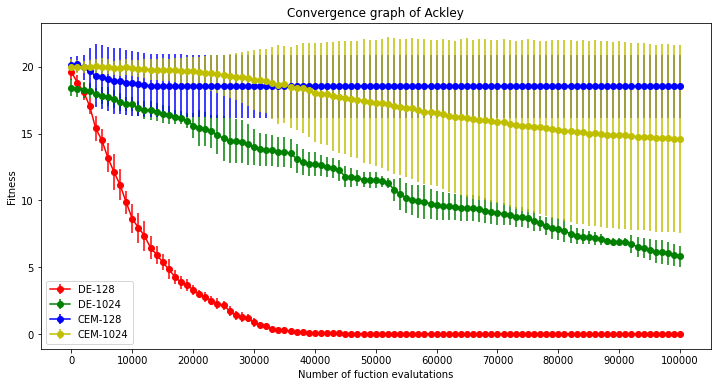

In [35]:
draw_convergence_graph(algorithm_names, colors, function_names[4], d_list[1], N_list, random_seed, runtimes)

## Objective mean table for each Population size

In [36]:
algorithm_names = ['DE', 'CEM']
function_names = ['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley']
d_list = [2, 10]
N_list = [32, 64, 128, 256, 512, 1024]
random_seed= 20520835
runtimes = 10

In [162]:
def draw_table(algorithm_names, function_name, d, N_list, random_seed, runtimes, alpha = 0.05):
  algorithm_final_fitness = []

  #take data
  for i in range(len(algorithm_names)):
    algorithm_final_fitness.append(pd.DataFrame(columns=[f'{random_seed + i}' for i in range(runtimes)]))

    for N in N_list:
      path = algorithm_names[i] + '/' + function_name + '/' + str(d) + '/' + str(N)
      final_fitness = []

      for j in range(runtimes):
        results = open(f"{path}/{algorithm_names[i]}_{function_name}_{d}_{N}_{random_seed + j}.log", 'r').read().split('\n')
        final_fitness.append(round(float(results[-2].split('\t')[1]), 3))
      
      df = pd.DataFrame(data=[final_fitness], columns=[f'{random_seed + i}' for i in range(runtimes)], index=[N])
      algorithm_final_fitness[i] = algorithm_final_fitness[i].append(df.copy())
  
  # print(algorithm_final_fitness[0].table())
  # fig, ax = plt.subplots()
  # plt.table(ax, algorithm_final_fitness[0])

  # render data to table with mean and standard deviation
  table = pd.DataFrame(columns=algorithm_names)
  highlight = {}
  min_mean = {}
  for i in range(len(N_list)):
    set1 = algorithm_final_fitness[0].iloc[i].values
    set2 = algorithm_final_fitness[1].iloc[i].values
    
    #check for statitcal significant
    highlight[N_list[i]] = stats.ttest_ind(set1, set2).pvalue < alpha

    # calulate mean and std of DE and CEM on Objective function
    set1_mean = round(algorithm_final_fitness[0].iloc[i].mean(), 3)
    set1_std = round(algorithm_final_fitness[0].iloc[i].std(), 3)

    set2_mean = round(algorithm_final_fitness[1].iloc[i].mean(), 3)
    set2_std = round(algorithm_final_fitness[1].iloc[i].std(), 3)


    min_mean[N_list[i]] = 'DE' if set1_mean < set2_mean else 'CEM'
    set1_cell = f'{set1_mean} ({set1_std})'
    set2_cell = f'{set2_mean} ({set2_std})'

    # import data to table
    data = []
    data.append(set1_cell)
    data.append(set2_cell)
    df = pd.DataFrame(data=[data], columns=algorithm_names, index=[N_list[i]])

    table = table.append(df.copy())
  
  table.index.name = 'Popsize N / λ'

  return table, highlight, min_mean

In [168]:
d = d_list[1]
function_name = function_names[4]
table, highlight, min_mean = draw_table(algorithm_names, function_name, d, N_list, random_seed, runtimes)
def highlight_max(x, highlight, min_mean):
  N = x.name
  return np.where(x.index == min_mean[N], "font-weight: bold;", None) if highlight[N] else [None, None]

table.style.set_caption(f'Table of {function_name} function d = {d}').apply(highlight_max, highlight=highlight, min_mean=min_mean, axis=1)

,DE,CEM
Popsize N / λ,,
32,0.0 (0.0),19.966 (0.825)
64,0.0 (0.0),19.494 (1.001)
128,0.0 (0.0),18.565 (2.356)
256,0.015 (0.003),17.349 (2.784)
512,1.874 (0.167),14.655 (5.904)
1024,5.823 (0.774),13.27 (6.399)


# IV. Visual implementation

In [237]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from IPython import display 
import time
import os

In [239]:
# %cd ..
%cd /content/GIF

/content/GIF


$f(x) = \displaystyle\sum_{i=1} ^{d} x_i^2$

In [188]:
def sphere(x, y):
  return x**2 + y**2

$f(x) = \displaystyle\sum_{i=1} ^{d} x_i^2 + ( \sum_{i=1} ^{d} 0.5ix_i)^2 + ( \sum_{i=1} ^{d} 0.5ix_i)^4$

In [189]:
def zakharov(x, y):
  
  return (x + y)**2 + (0.5*x + 0.5*2*y)**2 + (0.5*x + 0.5*2*y)**4

$f(x) = \displaystyle\sum_{i=1}^{d-1}[100(x_{i+1} -x_i^2)^2 + (x_i - 1)^2]$

In [190]:
def rosenbrock(x, y):
  return 100*(y - x**2)**2 + (x - 1)**2

$f(x) = \displaystyle - \sum_{i=1}^{d} \sin(x_i)\sin^{2m} (\frac {ix_i^2} {π}) $

In [191]:
def michalewicz(x, y, m=10):
  return -1 * (np.sin(x) * np.sin(x**2 / np.pi) ** (2*m) + np.sin(y) * np.sin(2 * y**2 / np.pi) ** (2*m) )

In [173]:
michalewicz(2.2, 1.57)

-1.801140718473825

$f(x) = \displaystyle -a \exp(-b \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2 } ) - \exp(\frac{1}{d} \sum_{i=1}^{d} \cos(cx_i) ) + a + \exp(1)$

In [174]:
def ackley(x, y, a=20, b=0.2, c=2*np.pi):
  return -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(c * x) + np.cos(c * y))) + a + np.e

In [175]:
ackley(0, 0)

4.440892098500626e-16

In [301]:
algorithms = ['DE', 'CEM']
algorithm = algorithms[1]
# bounds = [(-5.12, 5.12)]
# bounds = [(-5, 10)]
bounds = [(-5, 10)]
# bounds = [(0, np.pi)]
# bounds = [(-32.768, 32.768)]
np.random.seed(20520835)

# function = 'Sphere' 
# function = 'Zakharov' 
function = 'Rosenbrock' 
# function = 'Michalewicz' 
# function = 'Ackley' 

if algorithm == 'DE':
  # results, all, evals = de(Sphere, bounds=bounds*2, popsize=32, max_evaluations=100000)
  # results, all, evals = de(Zakharov, bounds=bounds*2, popsize=32, max_evaluations=100000)
  results, all, evals = de(Rosenbrock, bounds=bounds*2, popsize=32, max_evaluations=100000)
  # results, all, evals = de(Michalewicz, bounds=bounds*2, popsize=32, max_evaluations=100000)
  # results, all, evals = de(Ackley, bounds=bounds*2, popsize=32, max_evaluations=100000)
else:
  # results, all, evals = cem(Sphere, bounds=bounds*2, popsize=32, elite_frac=0.5, max_evaluations=100000)
  # results, all, evals = cem(Zakharov, bounds=bounds*2, popsize=32, elite_frac=0.5, max_evaluations=100000)
  results, all, evals = cem(Rosenbrock, bounds=bounds*2, popsize=32, elite_frac=0.5, max_evaluations=100000)
  # results, all, evals = cem(Michalewicz, bounds=bounds*2, popsize=32, elite_frac=0.5, max_evaluations=100000)
  # results, all, evals = cem(Ackley, bounds=bounds*2, popsize=32, elite_frac=0.5, max_evaluations=100000)

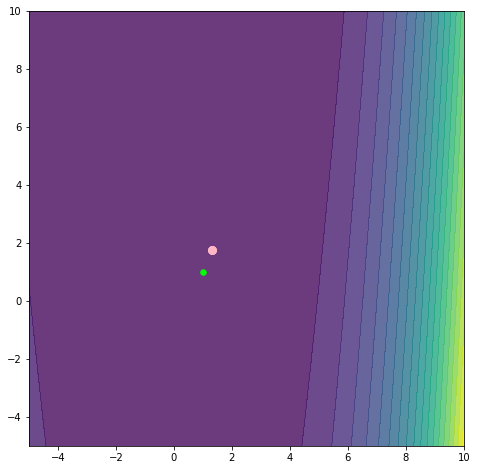

In [302]:
x = np.linspace(bounds[0][0], bounds[0][1], 100)
y = np.linspace(bounds[0][0], bounds[0][1], 100)

X, Y = np.meshgrid(x, y)

# Z = sphere(X,Y)
# best = [0, 0]

# Z = zakharov(X,Y)
# best = [0, 0]

Z = rosenbrock(X,Y)
best = [1, 1]

# Z = michalewicz(X,Y)
# best = [2.2, 1.57]

# Z = ackley(X,Y)
# best = [0, 0]

max_iters = len(all)

for iteration in range(0, 100):
    plt.figure(figsize=(8,8))
    plt.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.8)
    plt.axis('square')
    plt.scatter(best[0], best[1], s=30, c='#00FF00')
    plt.scatter(all[iteration][:,0], all[iteration][:,1], s=50, c='#FFB7C5')
    plt.show()
    time.sleep(0.1)
    if iteration < max_iters:
        display.clear_output(wait=True)

In [304]:
x = np.linspace(bounds[0][0], bounds[0][1], 100)
y = np.linspace(bounds[0][0], bounds[0][1], 100)

X, Y = np.meshgrid(x, y)

# Z = sphere(X,Y)
# best = [0, 0]

# Z = zakharov(X,Y)
# best = [0, 0]

Z = rosenbrock(X,Y)
best = [1, 1]

# Z = michalewicz(X,Y)
# best = [2.2, 1.57]

# Z = ackley(X,Y)
# best = [0, 0]

max_iters = len(all)
filenames = []

for iteration in range(0, 70):
    plt.figure(figsize=(8,8))
    plt.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.8)
    plt.axis('square')
    plt.scatter(best[0], best[1], s=30, c='#00FF00')
    plt.scatter(all[iteration][:,0], all[iteration][:,1], s=50, c='#FFB7C5')
    plt.plot()

    # create file name and append it to a list
    filename = f'{iteration}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()

    if iteration < max_iters:
        display.clear_output(wait=True)

# build gif
with imageio.get_writer(f'{algorithm}_{function}.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [305]:
!zip -r /content/GIF.zip /content/GIF

  adding: content/GIF/ (stored 0%)
  adding: content/GIF/CEM_Michalewicz.gif (deflated 42%)
  adding: content/GIF/.ipynb_checkpoints/ (stored 0%)
  adding: content/GIF/DE_Rosenbrock.gif (deflated 34%)
  adding: content/GIF/DE_Michalewicz.gif (deflated 41%)
  adding: content/GIF/DE_Sphere.gif (deflated 25%)
  adding: content/GIF/CEM_Ackley.gif (deflated 23%)
  adding: content/GIF/CEM_Zakharov.gif (deflated 50%)
  adding: content/GIF/CEM_Sphere.gif (deflated 25%)
  adding: content/GIF/DE_Ackley.gif (deflated 23%)
  adding: content/GIF/CEM_Rosenbrock.gif (deflated 35%)
  adding: content/GIF/DE_Zakharov.gif (deflated 49%)
